In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from helpers import read_echogram

In [2]:
class EchoGram:
    def __init__(self, filename, channels=None):
        self.filename = filename
        self.data, self.echo = self.test_overlay_wb_echo(filename, channels)
        self.df = pd.DataFrame(self.data)
        self.lat_lon_to_meters(self.df["longitude"].to_numpy(), self.df["latitude"].to_numpy())
        
        del self.data
        
    def test_overlay_wb_echo(self, filename, channels=None):
        """ Load sounding data and echogram and plot the entire sonar image. 
            The library, Python SLLIB, used in the helpers.py file, decodes the SL2 file format from Lowrance sonar sounder and
            converts it to two simple data types, one is data, a list of dictionaries, which is later converted to a pandas dataframe,
            a table with the values of the different variables that the sonar outputs, and the second data type is a ndarray that
            represents the image that the sonar outputs. 
            
            Input: 
            Filename: string containing the sl2 file location
            Channel: sonar sensor type
                - 0 = Primary (Traditional Sonar)
                - 1 = Secondary (Traditional Sonar)
                - 2 = DSI (Downscan Imaging)
                - 3 = Sidescan Left
                - 4 = Sidescan Right
                - 5 = Sidescan (Composite)
                Another other value is treated as Invalid.
        """
        data, echo = read_echogram(filename, channels)

        fig, axes = plt.subplots()
        axes.imshow(echo, aspect='auto')
        fig.show()
        #fig.savefig('sss.png', dpi=fig.dpi)
        return data, echo
    
    def lat_lon_to_meters(self, lon, lat, x0=-9147145.64754388, y0=3427601.097538607):
        """ Convert longitude and latitude to global X and Y coordinates in meters
            Inputs:
                lon: longitude 
                lat: latitude
                x0: X position of the origin in the new map
                y0: Y position of the origin in the new map
            NOTE: default of x0 and y0 is (an eyeballed) bottom left point in CITRA pond, Florida
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        
        self.X = X - x0
        self.Y = Y - y0
        self.df["X_m"] = np.copy(self.X)
        self.df["Y_m"] = np.copy(self.Y)
        
    def see_range(self, range):
        fig, ax = plt.subplots()
        ax.plot(self.X, self.Y, 'ko', ms=0.5)
        ax.plot(self.X[range[0]:range[1]], self.Y[range[0]:range[1]], 'ro', ms=0.5)
        ax.set_aspect('equal')

    def crop_data(self, start, end):
        self.echo = np.delete(self.echo, slice(start,end), 1)
        self.df = self.df.drop(self.df.index[range(start,end)])
        self.X = np.delete(self.X, slice(start,end))
        self.Y = np.delete(self.Y, slice(start,end))

### October 2021 datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

## File:Sonar_2021-10-16_12.53.38 Speed=4mph

  0%|          | 0.00/415M [00:00<?, ?B/s]

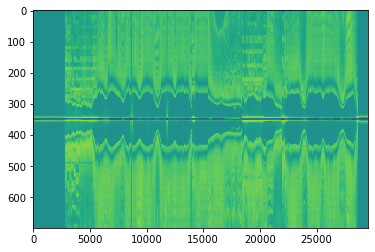

In [9]:
# Just run once to parse the sl2 file, then save the data of a variable in a file using pickle 
echo_4mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[5])

In [4]:
print(echo_4mph_101621.df.head())

dict_keys(['offset', 'previous_primary_offset', 'previous_secondary_offset', 'previous_downscan_offset', 'previous_left_sidescan_offset', 'previous_right_sidescan_offset', 'previous_composite_sidescan_offset', 'framesize', 'previous_framesize', 'channel', 'packetsize', 'frame_index', 'upper_limit', 'lower_limit', 'frequency', 'water_depth', 'keel_depth', 'gps_speed', 'temperature', 'lon_enc', 'lat_enc', 'water_speed', 'course', 'altitude', 'heading', 'flags', 'time1', 'has_altitude', 'has_heading', 'has_track', 'has_water_speed', 'has_position', 'has_packet', 'has_temperature', 'has_gps_speed', 'gps_speed_kph', 'longitude', 'latitude', 'water_depth_m', 'headersize', 'heading_deg'])
{'offset': 8, 'previous_primary_offset': 0, 'previous_secondary_offset': 0, 'previous_downscan_offset': 0, 'previous_left_sidescan_offset': 0, 'previous_right_sidescan_offset': 0, 'previous_composite_sidescan_offset': 8, 'framesize': 2944, 'previous_framesize': 0, 'channel': 5, 'packetsize': 2800, 'frame_ind

In [5]:
print("echo shape:",echo_4mph_101621.echo.shape)
print("type(data):",type(echo_4mph_101621.echo))

echo shape: (700, 29551)
type(data): <class 'list'>
length: 29551


In [12]:
rows, cols = echo_4mph_101621.echo.shape
vmin=min(echo_4mph_101621.echo.flat)
vmax=max(echo_4mph_101621.echo.flat)
print("min intensity=",vmin)
print("max intensity=",vmax)

min= -2143262300.0
max= 2141233300.0


## Visualize image segments with "hot" colors

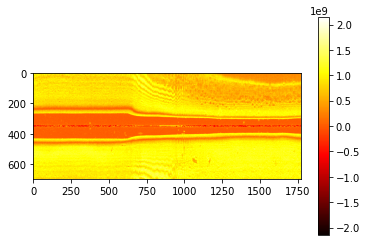

In [14]:
plt.imshow(echo_4mph_101621.echo[:,int(cols/2):int(cols*2.8/5)], cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

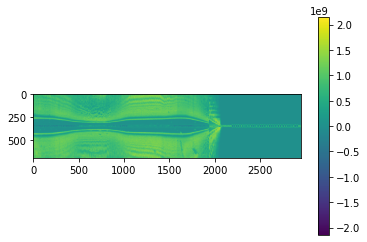

In [7]:
plt.imshow(echo_4mph_101621.echo[:,int(cols*9/10):-1],)
plt.colorbar()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

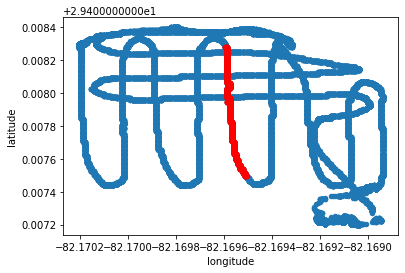

In [13]:
fig = plt.figure()
ax1 = echo_4mph_101621.df.plot.scatter(x="longitude", y="latitude")
echo_4mph_101621.df.loc[9600:10800,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax1)


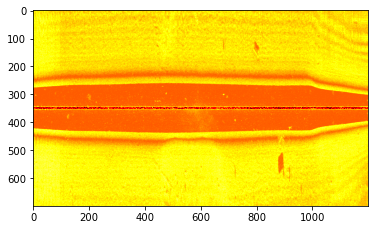

In [15]:
plt.imshow(echo_4mph_101621.echo[:,9600:10800], cmap='hot', vmin=vmin, vmax=vmax)

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

  0%|          | 0.00/327M [00:00<?, ?B/s]

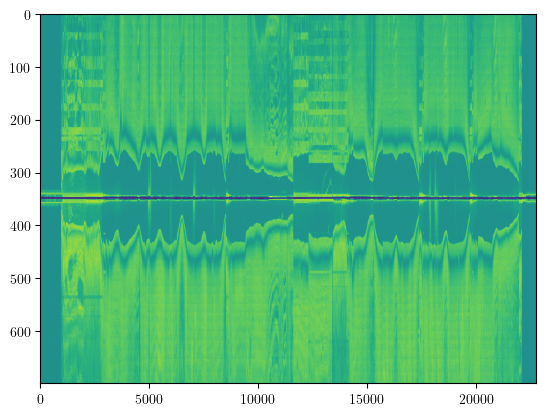

In [49]:
echogram6mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])

In [3]:
with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
    # Call load method to deserialze
    echogram6mph_101621 = pickle.load(file)
    
with open('processed_data/echogram6mph_101621.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(echogram6mph_101621, file)

length: 22784


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

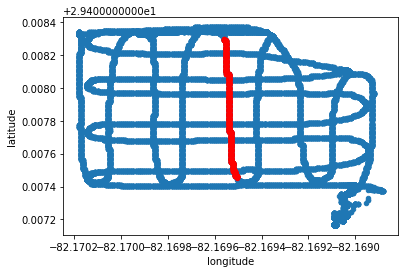

In [20]:
print("length:",len(echogram6mph_101621.data))
fig = plt.figure()
ax2 = echogram6mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram6mph_101621.df.loc[5600:6400,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2)

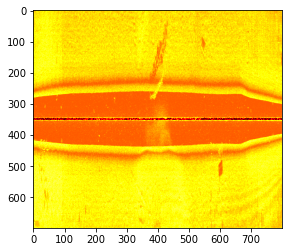

In [14]:
plt.imshow(echogram6mph_101621.echo[:,5600:6400], cmap='hot')

## File:Sonar_2021-10-16_14.38.24 Speed=7mph

  0%|          | 0.00/141M [00:00<?, ?B/s]

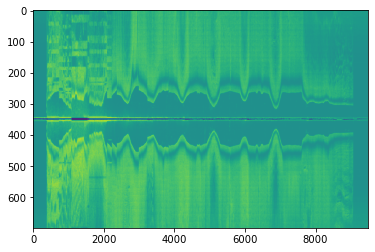

In [8]:
echogram7mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2', channels=[5])

length: 9491


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

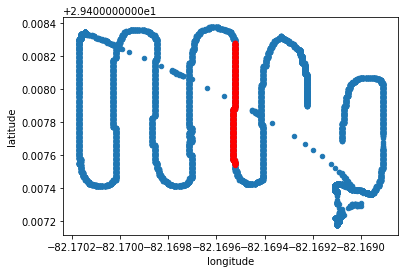

In [11]:
print("length:",len(echogram7mph_101621.data))
fig = plt.figure()
ax3 = echogram7mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram7mph_101621.df.loc[4400:5000,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax3)

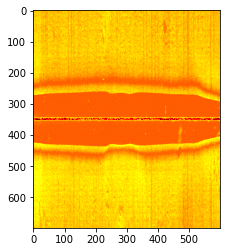

In [20]:
vmin=min(echogram7mph_101621.echo.flat)
vmax=max(echogram7mph_101621.echo.flat)
plt.imshow(echogram7mph_101621.echo[:,4400:5000], cmap='hot', vmin=vmin, vmax=vmax)

# DownScan Sonar

  0%|          | 0.00/415M [00:00<?, ?B/s]

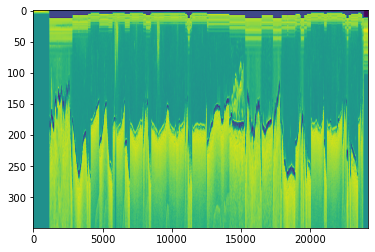

In [5]:
downscan = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[2], depthline=False)

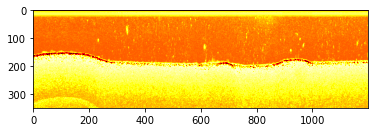

In [6]:
plt.imshow(downscan.echo[:,9600:10800], cmap='hot')

## North-South and East-West comparisson

In [3]:
import os
files = os.listdir('log-data-lowrance/02_20_22')
print(files)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2']


  0%|          | 0.00/417M [00:00<?, ?B/s]

  0%|          | 0.00/277M [00:00<?, ?B/s]

  0%|          | 0.00/194M [00:00<?, ?B/s]

  0%|          | 0.00/369M [00:00<?, ?B/s]

  0%|          | 0.00/431M [00:00<?, ?B/s]

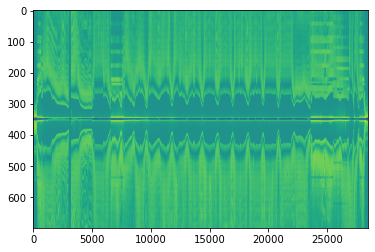

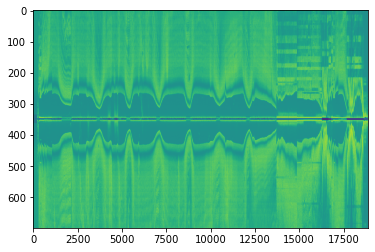

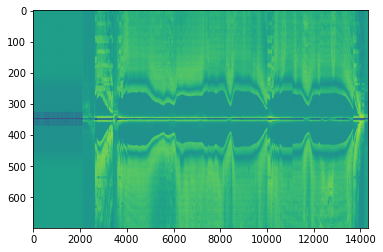

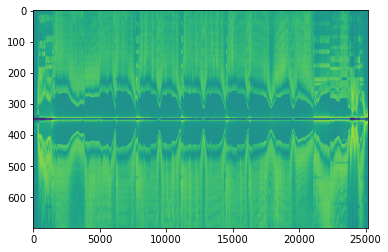

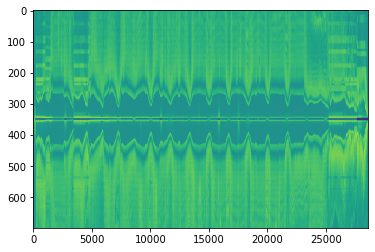

In [16]:
dataset_012022 = {}
for file in files:
    dataset_012022[file] = EchoGram('./log-data-lowrance/02_20_22/'+file, channels=[5])

In [526]:
# Run this to save the variables to a file
with open('processed_data/noso.txt', 'wb') as fl: 
    # A new file will be created
    print("Checking the NO_SO variable exists. First element: ", NO_SO[0])
    pickle.dump(NO_SO, fl)
with open('processed_data/eawe.txt', 'wb') as fl: 
    print("Checking the EA_WE variable exists. First element: ", EA_WE[0])   
    pickle.dump(EA_WE, fl)
with open('processed_data/dataset_012022.txt', 'wb') as fl:  
    print("Checking the dataset_012022 variable exists. Type: ", type(dataset_012022))   
    pickle.dump(dataset_012022, fl)
with open('processed_data/cropped_dataset.txt', 'wb') as fl:  
    print("Checking the cropped_dataset variable exists. Type: ", type(cropped_dataset))   
    pickle.dump(cropped_dataset, fl)
with open('processed_data/E_array.txt', 'wb') as fl:  
    print("Checking the E_array variable exists. Type: ", type(cropped_dataset))   
    pickle.dump(E_array, fl)

Checking the NO_SO variable exists. First element:  [11680 12687     0]
Checking the EA_WE variable exists. First element:  [   0 1300    1]
Checking the dataset_012022 variable exists. Type:  <class 'dict'>
Checking the cropped_dataset variable exists. Type:  <class 'dict'>
Checking the E_array variable exists. Type:  <class 'dict'>


In [4]:
# Run this to retrieve the variables from a file
with open('processed_data/noso.txt', 'rb') as fl:
    # Call load method to deserialze
    NO_SO = pickle.load(fl)
with open('processed_data/eawe.txt', 'rb') as fl:
    EA_WE = pickle.load(fl)
with open('processed_data/dataset_012022.txt', 'rb') as fl:
    dataset_012022 = pickle.load(fl)
with open('processed_data/cropped_dataset.txt', 'rb') as fl:
    cropped_dataset = pickle.load(fl)

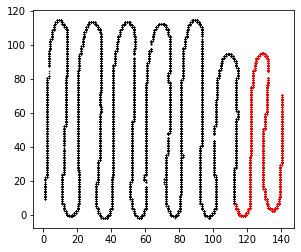

In [46]:
# Visualize and crop the datapoints that are garbage
start = 0
end = 3000
index_f = 0
#dataset_012022[files[index_f]].crop_data(start, end)
dataset_012022[files[index_f]].see_range([start,end])

xmin =  1.0033640917390585
xmax =  140.47097257710993
ymin =  -2.006728178821504
ymax =  114.38350624218583


<Figure size 432x288 with 0 Axes>

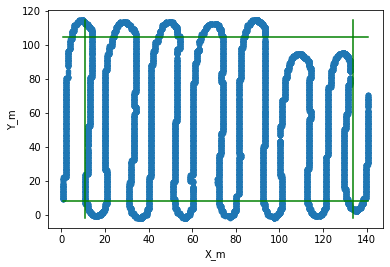

In [6]:
# approximate limits of axis for plotting
index_f = 0

xmin = dataset_012022[files[index_f]].df["X_m"].min()  # xmin =  1.0033640917390585
xmax = dataset_012022[files[index_f]].df["X_m"].max()  # xmax =  140.47097257710993
ymin = dataset_012022[files[index_f]].df["Y_m"].min()  # ymin =  -2.006728178821504
ymax = dataset_012022[files[index_f]].df["Y_m"].max()  # ymax =  114.38350624218583

print("xmin = ", xmin)
print("xmax = ", xmax)
print("ymin = ", ymin)
print("ymax = ", ymax)

fig = plt.figure()
ax2 = dataset_012022[files[index_f]].df.plot.scatter(x="X_m", y="Y_m")
ax2.plot([xmin+10]*2,[ymin,ymax], 'g') #xmin line
ax2.plot([xmax-7]*2,[ymin,ymax], 'g') #xmax line
ax2.plot([xmin,xmax],[ymin+10]*2, 'g') #ymin line
ax2.plot([xmin,xmax],[ymax-10]*2, 'g') #ymax line

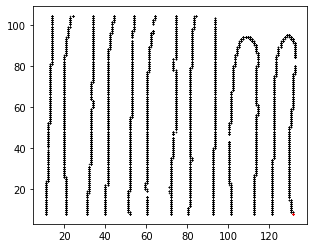

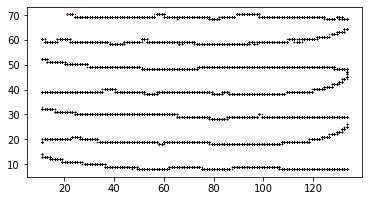

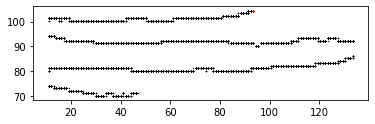

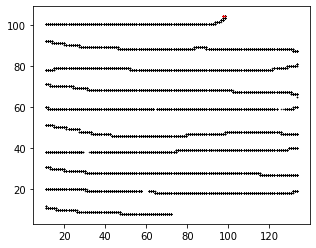

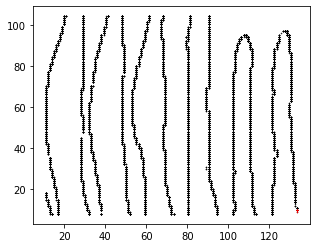

In [96]:
def select_and_crop_square(sonar_class):

    indexes = np.where(sonar_class.X < xmin+10)[0]
    indexes = np.concatenate((indexes, np.where(sonar_class.X > xmax-7)[0]))
    indexes = np.concatenate((indexes, np.where(sonar_class.Y < ymin+10)[0]))
    indexes = np.concatenate((indexes, np.where(sonar_class.Y > ymax-10)[0]))
    sonar_class.echo = np.delete(sonar_class.echo, indexes, 1)
    sonar_class.df = sonar_class.df.drop(sonar_class.df.index[indexes])
    sonar_class.X = np.delete(sonar_class.X, indexes)
    sonar_class.Y = np.delete(sonar_class.Y, indexes)

index_f = 0

for ii in range(len(files)):
    select_and_crop_square(cropped_dataset[files[ii]])
    
    cropped_dataset[files[ii]].see_range([0,10])

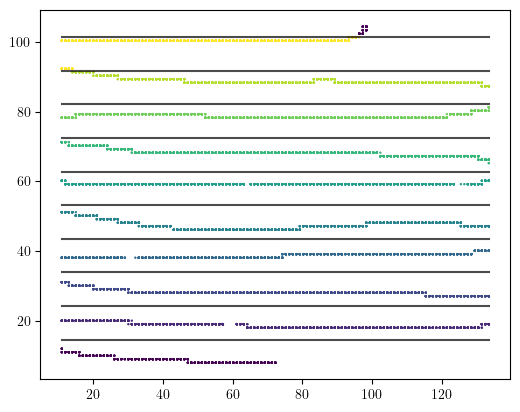

In [522]:
index_f = 3

def divide_and_conquer(sonar_class, nums, index_f, EA_WE):
    """Function that divides the raster patterns into lines by assuming lines are uniformly separated
    """
    maxxpo = sonar_class.X.max()
    minxpo = sonar_class.X.min()
    maxypo = sonar_class.Y.max()
    minypo = sonar_class.Y.min()
    
    dy = (maxypo - minypo)/nums
    index_dict = {} #dictionary is for not used idea of not having start end but all the indices
    start = np.copy(minypo) - 3
    end = start + dy + 0.1
    colors = np.zeros_like(sonar_class.Y)
    fig, ax = plt.subplots()
    eawe = np.array([[0, 0, 0]])
    for ii in range(nums):  # if statements to account for the drifts and non uniform rasters in the data
        if index_f == 1:
            if (ii == 5 or ii == 10):
                start += 4 
                end += 4 
        if index_f == 1:
            if (ii == 0 ):
                start += 1 
                end += 1
        if index_f == 2:
            if (ii == 0 ):
                start += 1 
                end += 1  
        indexes = np.where(sonar_class.Y > start)[0]
        index_dict[str(ii)] = np.where(sonar_class.Y[indexes] < end)[0]
        start += dy
        end += dy
        eawe = np.append(eawe, [[index_dict[str(ii)][0], index_dict[str(ii)][-1], index_f]], axis=0)
        colors[index_dict[str(ii)]] = ii
        ax.plot([minxpo,maxxpo], [start]*2, 'k', alpha=0.7) #xmax line
    
    ax.scatter(sonar_class.X, sonar_class.Y, c=colors, s=0.5)
    ax.set_aspect('equal')
    return eawe[1:-1]

ea_we1 = divide_and_conquer(cropped_dataset[files[index_f]], 10, index_f, EA_WE)
#EA_WE = np.concatenate((EA_WE, ea_we, ea_we1, ea_we2))  # join the ea_we datapoints of each files to a total matrix
#print("EA_WE: \n",EA_WE)

NO_SO= 
 [[11680 12687     0]
 [10668 11679     0]
 [ 9651 10667     0]
 [ 8668  9650     0]
 [ 7666  8667     0]
 [ 6676  7665     0]
 [ 5670  6675     0]
 [ 4708  5669     0]
 [ 3741  4707     0]
 [ 2910  3740     0]
 [ 1888  2834     0]
 [ 1016  1887     0]
 [    0  1000     4]
 [ 1400  2300     4]
 [ 2400  3400     4]
 [ 3800  4800     4]
 [ 4900  6100     4]
 [ 6200  7400     4]
 [ 7500  8600     4]
 [10100 11280     4]
 [12600 13870     4]]


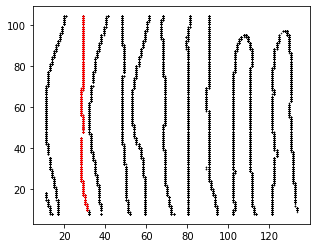

In [183]:
# Manually add the lines for the files where the raster pattern that are really non uniform

start= 12600
end = 13870
index_f = 4
cropped_dataset[files[index_f]].see_range([start,end])

# Uncomment to include line 
#NO_SO = np.append(NO_SO, [[start, end, index_f]], axis=0)
print("NO_SO= \n", NO_SO)

# Uncomment to include line 
#EA_WE = np.append(EA_WE, [[start, end, index_f]], axis=0)

In [512]:
def dir_comparison(no_so_model, no_so, ea_we_model, ea_we, is_plot=True):

    # Find index of minimumn distance between the average of two lines to start the search
    avg_lon_no_so = no_so_model.df['X_m'].to_numpy().mean()
    avg_lat_ea_we = ea_we_model.df['Y_m'].to_numpy().mean()
    ea_we_in_avg = np.argmin(np.abs(ea_we_model.df['X_m'].to_numpy()[ea_we]-avg_lon_no_so))
    no_so_in_avg = np.argmin(np.abs(no_so_model.df['Y_m'].to_numpy()[no_so]-avg_lat_ea_we))
    
    # 
    diffx = no_so_model.df['X_m'].to_numpy()[no_so[0]] - ea_we_model.df['X_m'].to_numpy()[ea_we[0]]
    diffy = no_so_model.df['Y_m'].to_numpy()[no_so[0]] - ea_we_model.df['Y_m'].to_numpy()[ea_we[0]]
    min_distance = np.sqrt(diffx**2 + diffy**2) 
    no_so_in = np.copy(no_so[no_so_in_avg])
    ea_we_in = np.copy(ea_we[ea_we_in_avg])

    # Define points close to the average intersection to search for real intersection
    dn_min = 0 if no_so_in_avg < 50 else 50
    de_min = 0 if ea_we_in < 50 else 50
    dn_max = len(no_so)-no_so_in_avg if no_so_in_avg+50 > len(no_so) else 50
    de_max = len(ea_we)-ea_we_in_avg if ea_we_in_avg+50 > len(ea_we) else 50
    
    # Run the intersection search to points close the average intersection (to not search for the entire run)
    nn = np.array(no_so[no_so_in_avg-dn_min:no_so_in_avg+dn_max])
    ee = np.array(ea_we[0:ea_we_in_avg+de_max])
    
    for ii in nn:
        for jj in ee:
            diffx = no_so_model.df['X_m'].to_numpy()[ii] - ea_we_model.df['X_m'].to_numpy()[jj]
            diffy = no_so_model.df['Y_m'].to_numpy()[ii] - ea_we_model.df['Y_m'].to_numpy()[jj]
            distance = np.sqrt(diffx**2 + diffy**2) 
            #print(ii, jj)
            if distance < min_distance:
                no_so_in = np.copy(ii)
                ea_we_in = np.copy(jj)
                #print('assign',no_so_in)
                #print('assign',ea_we_in)
                min_distance = np.copy(distance)    
    
    # Calculate difference in index to visualize the two paths intersecting
    diff_in = ea_we_in - no_so_in

    # Load depth values in cm
    no_so_depth = no_so_model.df['water_depth_m'].to_numpy()[no_so]*100
    ea_we_depth = ea_we_model.df['water_depth_m'].to_numpy()[ea_we]*100

    # return intersection 1 if there is an intersection (defined as less than the threshold)
    dist_threshold = 20
    is_crossing = 1 if min_distance < dist_threshold else 0
    
    # Exit function when there is no crossing or if points closer to the intersection are out of bounds of array
    poly_pts = 5 # half of number of points used to fir the polynomial
    if (no_so_in-poly_pts <= 0 or ea_we_in-poly_pts <= 0 or no_so_in+poly_pts >= max(no_so) or ea_we_in+poly_pts >= max(ea_we) or not is_crossing):
        if is_plot: # for debugging
            print(no_so_in-poly_pts <= 0)
            print(ea_we_in-poly_pts <= 0)
            print(ea_we_in+poly_pts >= max(ea_we))
            print(no_so_in+poly_pts >= max(no_so))
            print(not is_crossing)
        return 0, 0
    
    # Fit and generate a polynomial regressor to points close to intersection
    no_so_poly_in = np.arange(no_so_in-poly_pts, no_so_in+poly_pts) # indices
    ea_we_poly_in = np.arange(ea_we_in-poly_pts, ea_we_in+poly_pts) 
    no_so_poly = np.poly1d(np.polyfit(no_so_poly_in, no_so_model.df['water_depth_m'].to_numpy()[no_so_poly_in]*100, 3))
    ea_we_poly = np.poly1d(np.polyfit(ea_we_poly_in, ea_we_model.df['water_depth_m'].to_numpy()[ea_we_poly_in]*100, 3))    
    
    E = no_so_poly(no_so_in) - ea_we_poly(ea_we_in) # Difference of depth between lines
    
    if is_plot: 
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(np.array(no_so)+diff_in, no_so_depth, c='blue', s=4, alpha=0.5, label='NS Sampled Points')
        ax.scatter(ea_we, ea_we_depth, c='red', s=4, alpha=0.5, label='EW Sampled Points')
        ax.plot(no_so_poly_in+diff_in, no_so_poly(no_so_poly_in), c='mediumblue',label='NS fitted polynomial')
        ax.plot(ea_we_poly_in, ea_we_poly(ea_we_poly_in), c='firebrick', label='EW fitted polynomial')
        min_depth = np.min([np.min(no_so_depth), np.min(ea_we_depth)]) # get indices at edges of data range
        max_depth = np.max([np.max(no_so_depth), np.max(ea_we_depth)])
        ax.plot(np.array([no_so_in]*2)+diff_in,[min_depth,max_depth], '--k', label='Intersection')
        ax.set_ylabel('Depth [cm]')
        ax.set_xlabel('Data points')
        ax.legend()# use ' loc="lower right" ' to position legend
        plt.xlim((ea_we_in-80, ea_we_in+80))
        plt.ylim((ea_we_poly(ea_we_in)-40, ea_we_poly(ea_we_in)+40))
        plt.show()
        print("Error: ", E, "[cm]")
        print("Distance between points: ", min_distance, "[cm]")
        fig.savefig('paper_figures/comparisson1.jpg', dpi=fig.dpi)

    return E, is_crossing

7003 1112
min dist: 18.41931623068557


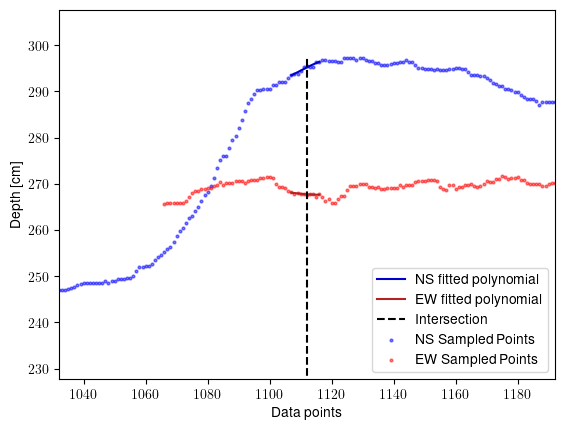

Error:  27.46304996975232 [cm]
Distance between points:  18.41931623068557 [cm]


(27.46304996975232, 1)

In [524]:
no_so1 = [ 6676,  7665,     0]
ea_we1 = [ 1066,  2432,     3]
no_so_range1 = range(no_so1[0], no_so1[1])
ea_we_range1 = range(ea_we1[0], ea_we1[1])
dir_comparison(dataset_012022[files[no_so1[2]]], no_so_range1, dataset_012022[files[ea_we1[2]]], ea_we_range1, is_plot=True)

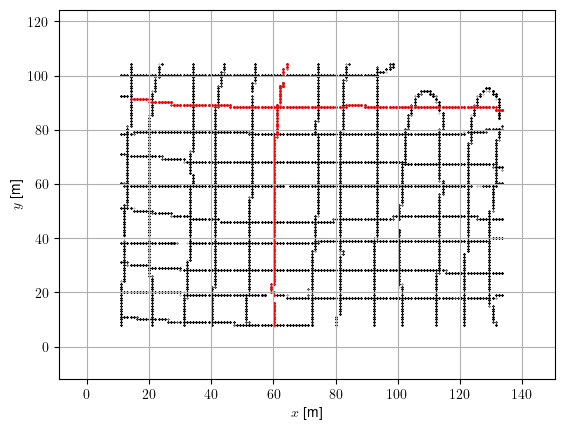

In [525]:
plt.style.use("default")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

fig, ax = plt.subplots()
ax.scatter(cropped_dataset[files[no_so1[2]]].X, cropped_dataset[files[no_so1[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[ea_we1[2]]].X, cropped_dataset[files[ea_we1[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[no_so1[2]]].X[no_so_range1], cropped_dataset[files[no_so1[2]]].Y[no_so_range1], c='r', s=0.1, )
ax.scatter(cropped_dataset[files[ea_we1[2]]].X[ea_we_range1], cropped_dataset[files[ea_we1[2]]].Y[ea_we_range1], c='r', s=0.1)
#ax.set_aspect('equal')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
plt.xlim(xmin-10, xmax+10)  
plt.ylim(ymin-10, ymax+10)
plt.grid()
plt.show()
fig.savefig('paper_figures/pattern1.jpg', dpi=fig.dpi)

4423 4683
min dist: 0.0


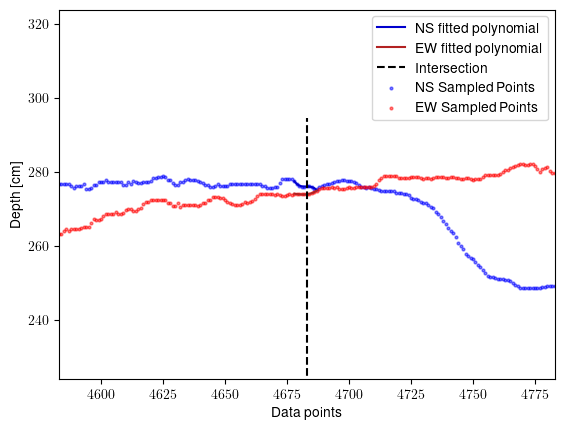

Error:  2.0829793512821198 [cm]
Distance between points:  0.0 [cm]


(2.0829793512821198, 1)

In [499]:
no_so2 = [ 3800,  4800,     4]
ea_we2 = [ 4400,  5750,     1]
no_so_range2 = range(no_so2[0], no_so2[1])
ea_we_range2 = range(ea_we2[0], ea_we2[1])
dir_comparison(cropped_dataset[files[no_so2[2]]], no_so_range2, cropped_dataset[files[ea_we2[2]]], ea_we_range2, is_plot=True)

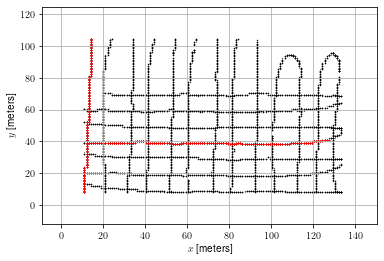

In [379]:
fig, ax = plt.subplots()
ax.scatter(cropped_dataset[files[no_so2[2]]].X, cropped_dataset[files[no_so2[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[ea_we2[2]]].X, cropped_dataset[files[ea_we2[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[no_so2[2]]].X[no_so_range2], cropped_dataset[files[no_so2[2]]].Y[no_so_range2], c='r', s=0.1, )
ax.scatter(cropped_dataset[files[ea_we2[2]]].X[ea_we_range2], cropped_dataset[files[ea_we2[2]]].Y[ea_we_range2], c='r', s=0.1)
#ax.set_aspect('equal')
ax.set_xlabel('$x$ [meters]')
ax.set_ylabel('$y$ [meters]')
plt.xlim(xmin-10, xmax+10)  
plt.ylim(ymin-10, ymax+10)
plt.grid()
plt.show()
fig.savefig('paper_figures/pattern2.jpg', dpi=fig.dpi)

In [11]:
# Save values to .mat file 
def to_mat():
    import scipy.io
    no_so_X_m = dataset_012022[files[0]].df['X_m'].to_numpy()
    no_so_Y_m = dataset_012022[files[0]].df['Y_m'].to_numpy()
    no_so_depth_m = dataset_012022[files[0]].df['water_depth_m'].to_numpy()
    ea_we_X_m = dataset_012022[files[3]].df['X_m'].to_numpy()
    ea_we_Y_m = dataset_012022[files[3]].df['Y_m'].to_numpy()
    ea_we_depth_m = dataset_012022[files[3]].df['water_depth_m'].to_numpy()
    fieldnames = ['no_so_X_m', 'no_so_Y_m', 'no_so_depth_m', 'ea_we_X_m', 'ea_we_Y_m', 'ea_we_depth_m']
    data = {'no_so_X_m':no_so_X_m, 'no_so_Y_m':no_so_Y_m, 'no_so_depth_m':no_so_depth_m, 'ea_we_X_m':ea_we_X_m, 
            'ea_we_Y_m':ea_we_Y_m, 'ea_we_depth_m':ea_we_depth_m}
    scipy.io.savemat('data.mat', data)
        
to_mat()

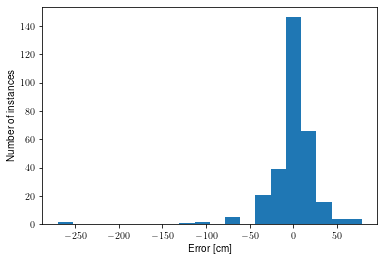

In [488]:
# Run comparisson algorithm for all combinations of intersection (including all files)
E_array = []
ii = 0
is_plot = False

for no_so in NO_SO:
    for ea_we in EA_WE:
        no_so_range = range(no_so[0], no_so[1])
        ea_we_range = range(ea_we[0], ea_we[1])
        E, is_crossing = dir_comparison(dataset_012022[files[no_so[2]]], no_so_range,
                                      dataset_012022[files[ea_we[2]]], ea_we_range, is_plot=False)
        E_array.append(E)
        # Removes the difference if the lines do not cross (distance more than threshold)
        if not is_crossing:
            E_array = E_array[:-1] 
        
        if is_plot:
            print(ii)
            print("noso: ",no_so)
            print("eawe: ",ea_we)
            fig, ax = plt.subplots()
            ax.plot(dataset_012022[files[no_so[2]]].X[no_so_range], dataset_012022[files[no_so[2]]].Y[no_so_range], 'k', ms=0.5, )
            ax.plot(dataset_012022[files[ea_we[2]]].X[ea_we_range], dataset_012022[files[ea_we[2]]].Y[ea_we_range], 'ro', ms=0.5)
            ax.set_aspect('equal')
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.show()
            #time.sleep(2)
            ii +=1


E_array = np.array(E_array)
plt.hist(E_array, bins=20)  
plt.ylabel('Number of instances')
plt.xlabel('Error [cm]');


Total # of points:  300
Median:  2.407231330871582
Standard Deviation:  19.900328608524983


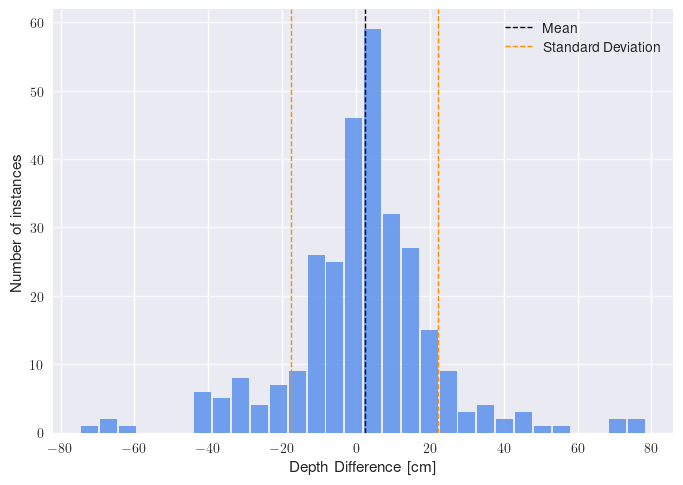

In [518]:
plt.style.use("seaborn-deep")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

print("Total # of points: ",len(E_array))
print("Median: ",np.median(E_array))
print("Standard Deviation: ",E_array.std())

#E_array = E_array[E_array > -75]

fig, axes = plt.subplots()
n, bins, patches = plt.hist(x=E_array, bins='auto', color='cornflowerblue',
                            alpha=0.9, rwidth=0.9)
plt.axvline(np.median(E_array), color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(np.median(E_array)+E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, label="Standard Deviation")
plt.axvline(np.median(E_array)-E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, )
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Number of instances')
plt.xlabel('Depth Difference [cm]')
#plt.title('North-South and East West depth comparisson')
plt.legend()
plt.savefig('paper_figures/error_hist.png', dpi=fig.dpi)